# Travelling Salesperson Plots used in Slides

Imports

In [1]:
from ortools.constraint_solver import pywrapcp, routing_enums_pb2
from tsp_examples import manhattan, manhattan_capa
import networkx as nx
from itertools import chain
import matplotlib.pyplot as plt
%matplotlib inline

## Without capacities

In [2]:
example = manhattan

city_names = example.names
distance = example.distance
num_cities = example.num_cities
num_vehicles = example.num_vehicles
depot_index = example.depot_index

# not used in non-plotting code
nodes = example.nodes

Helper function to generate plot with grid

In [3]:
def make_ax():
    fig, ax = plt.subplots(figsize=(10,8))
    ax.set_xlim(-1, 9)
    ax.set_ylim(9, -1)
    ax.set_xticks([0,1,2,3,4,5,6,7,8])
    ax.set_yticks([8,7,6,5,4,3,2,1,0])
    ax.xaxis.tick_top()
    ax.grid()
    return ax

In [4]:
def plot_manhattan(nodes, node_color='dodgerblue', graph=None, demands=None):
    ax = make_ax()

    # plot sth with matplotlib
    #ax.plot([1,2,3,4], 'go-')

    pos = {k:v for k, v in enumerate(nodes)}

    G = nx.DiGraph()
    G.add_nodes_from(pos.keys())

    colors = ['black'] + [node_color] * (num_cities-1)
    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=400, node_color='white', edgecolors=colors, linewidths=3)
    
    if demands is not None:
        # hacky way to plot labels beside node. Adjust spaces count if you change figure size
        labels = {k:"     {}   {}".format(k, d) for k, d in zip(pos.keys(), demands)}
        labels[0] = 0
    else:
        labels = {k:k for k, _ in pos.items()}
    nx.draw_networkx_labels(G, pos, labels=labels, ax=ax, font_color=node_color, font_size=10, font_weight='bold')
    
    if graph is not None:
        G.add_edges_from(graph)
        nx.draw_networkx_edges(G, pos, ax=ax, arrows=True, arrowsize=20, width=2, edge_color=node_color)

    plt.show()

#### Manhattan nodes

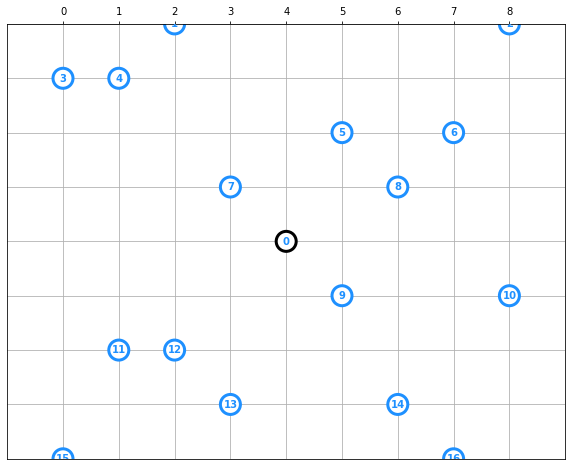

In [5]:
plot_manhattan(nodes)

#### One vehicle tour of Manhattan nodes

Note: There are a few optimal routes with distance 48, the difference is in the upper right quadrant

Total distance: 48


/home/tuxtimo/hslu/modules/hslu-aiso/env/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/tuxtimo/hslu/modules/hslu-aiso/env/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


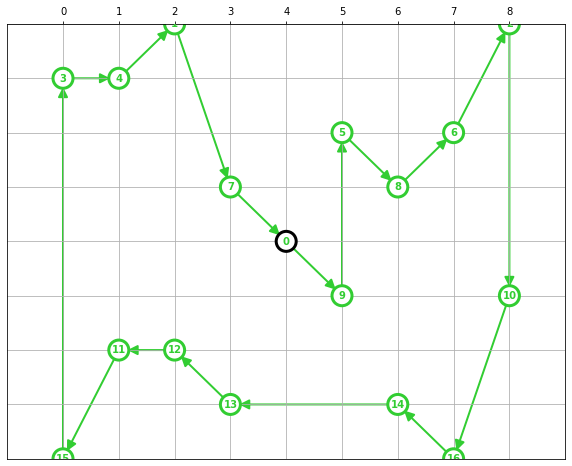

In [6]:
routing = pywrapcp.RoutingModel(num_cities, num_vehicles, depot_index)
routing.SetArcCostEvaluatorOfAllVehicles(distance)
parameters = pywrapcp.RoutingModel.DefaultSearchParameters()
parameters.first_solution_strategy = (routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
parameters.local_search_metaheuristic = (routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
parameters.time_limit_ms = 10000
assignment = routing.SolveWithParameters(parameters)
if assignment:
    graph = []
    print("Total distance: {}".format(assignment.ObjectiveValue()))
    for vehicle_num in range(routing.vehicles()):
        index = routing.Start(vehicle_num)  # index of the variable for the starting node
        a = routing.IndexToNode(index)
        while not routing.IsEnd(index):
            index = assignment.Value(routing.NextVar(index))
            b = routing.IndexToNode(index)
            graph.append((a,b))
            a = routing.IndexToNode(index)
graph.append((a, 0))
plot_manhattan(nodes, node_color='limegreen', graph=graph)

## With capacities

In [7]:
example = manhattan_capa

city_names = example.names
distance = example.distance
num_cities = example.num_cities
num_vehicles = example.num_vehicles
depot_index = example.depot_index
demand = example.demand
capacities = example.capacities

# not used in non-plotting code
nodes = example.nodes
demands = example.demands

#### Manhattan nodes with demands

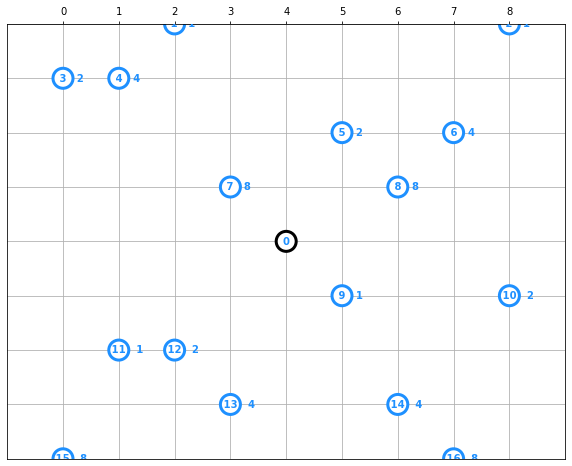

In [8]:
plot_manhattan(nodes, node_color='dodgerblue', graph=None, demands=demands)

#### Manhattan with four vehicles

In [9]:
def plot_manhattan2(all_nodes, tour_colors, graphs=None, all_demands=None):
    ax = make_ax()

    for graph, color in zip(graphs, tour_colors):
        G = nx.DiGraph()
        node_indices = list(set(chain.from_iterable(graph)))
        nodes = [all_nodes[i] for i in node_indices]
        demands = [all_demands[i] for i in node_indices]
        pos = {k:v for k, v in zip(node_indices, nodes)}
        
        G.add_nodes_from(pos.keys())
        G.add_edges_from(graph)
        
        color_list = ['black'] + [color] * (len(nodes)-1)
        nx.draw_networkx_nodes(G, pos, ax=ax, node_size=400, node_color='white', edgecolors=color_list, linewidths=3)
        nx.draw_networkx_edges(G, pos, ax=ax, arrows=True, arrowsize=20, width=2, edge_color=color)
        labels = {k:"     {}   {}".format(k, d) for k, d in zip(pos.keys(), demands)}
        labels[0] = 0
        nx.draw_networkx_labels(G, pos, labels=labels, ax=ax,
                                font_color=color, font_size=10, font_weight='bold')
    plt.show()

Total distance: 64


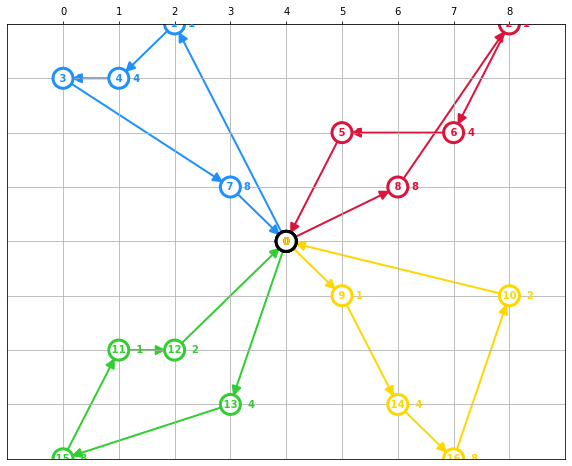

In [10]:
routing = pywrapcp.RoutingModel(num_cities, num_vehicles, depot_index)
routing.SetArcCostEvaluatorOfAllVehicles(distance)
routing.AddDimensionWithVehicleCapacity(demand, 0, capacities, True, "capacity")
parameters = pywrapcp.RoutingModel.DefaultSearchParameters()
parameters.first_solution_strategy = (routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
parameters.local_search_metaheuristic = (routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
parameters.time_limit_ms = 10000
assignment = routing.SolveWithParameters(parameters)
if assignment:
    graphs = []
    print("Total distance: {}".format(assignment.ObjectiveValue()))
    for vehicle_num in range(routing.vehicles()):
        graph = []
        index = routing.Start(vehicle_num)  # index of the variable for the starting node
        a = routing.IndexToNode(index)
        while not routing.IsEnd(index):
            index = assignment.Value(routing.NextVar(index))
            b = routing.IndexToNode(index)
            graph.append((a,b))
            a = routing.IndexToNode(index)
        graph.append((a, 0))
        graphs.append(graph)
plot_manhattan2(nodes, tour_colors=['dodgerblue', 'limegreen', 'crimson', 'gold'], graphs=graphs, all_demands=demands)

#### Below a solution (not beautified) that works with the new or-tools 7+

In [11]:
def print_solution(manager, routing, assignment):
    print('Objective: {} miles'.format(assignment.ObjectiveValue()))
    graph = []
    index = routing.Start(0)
    a = manager.IndexToNode(index)
    plan_output = 'Route for vehicle 0:\n'
    route_distance = 0
    while not routing.IsEnd(index):
        plan_output += ' {} ->'.format(manager.IndexToNode(index))
        previous_index = index
        index = assignment.Value(routing.NextVar(index))
        b = manager.IndexToNode(index)
        graph.append((a,b))
        a = manager.IndexToNode(index)
        route_distance += routing.GetArcCostForVehicle(manager.IndexToNode(previous_index),
                                                       manager.IndexToNode(index), 0) # 0 is vehicle_id
    plan_output += ' {}\n'.format(manager.IndexToNode(index))
    graph.append((a, 0))
    plan_output += 'Route distance: {}miles\n'.format(route_distance)
    print(plan_output)
    total_distance = 0
    for frm, to in graph:
        total_distance = total_distance + distance(frm, to)
    print("total dist", total_distance)
    return graph

In [12]:
def distance_callback(from_index, to_index):
    """Returns the distance between the two nodes."""
    # Convert from routing variable Index to distance matrix NodeIndex.
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return distance(from_node, to_node)

In [13]:
# Create the routing index manager.
manager = pywrapcp.RoutingIndexManager(num_cities, num_vehicles, depot_index)

AttributeError: module 'ortools.constraint_solver.pywrapcp' has no attribute 'RoutingIndexManager'

In [ ]:
# Create Routing Model.
routing = pywrapcp.RoutingModel(manager)

In [ ]:
# Define cost of each arc.
transit_callback_index = routing.RegisterTransitCallback(distance_callback)
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

In [ ]:
dimension_name = 'Distance'
routing.AddDimension(
    transit_callback_index,
    0,  # no slack
    100,  # vehicle maximum travel distance
    True,  # start cumul to zero
    dimension_name)
distance_dimension = routing.GetDimensionOrDie(dimension_name)
distance_dimension.SetGlobalSpanCostCoefficient(100)

In [ ]:
# Setting first solution heuristic.
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
search_parameters.local_search_metaheuristic = (routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
search_parameters.time_limit.seconds = 10

In [ ]:
# Solve the problem.
solution = routing.SolveWithParameters(search_parameters)

In [ ]:
# Print solution on console.
if solution:
    graph = print_solution(manager, routing, solution)
    ax = make_ax()

    pos = {k:v for k, v in enumerate(nodes)}

    G = nx.DiGraph()
    G.add_nodes_from(pos.keys())
    G.add_edges_from(graph)

    col = 'limegreen'
    colors = ['black'] + [col] * (num_cities-1)
    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=400, node_color='white', edgecolors=colors, linewidths=3)
    nx.draw_networkx_labels(G, pos, ax=ax, font_color=col, font_size=10, font_weight='bold')
    nx.draw_networkx_edges(G, pos, ax=ax, arrows=True, arrowsize=20, width=2, edge_color=col)

    plt.show()
else:
    print("No solution found")